# Regrid MLD from deBoyer et al (2004)

This notebook documents the steps needed to regrid the MLD dataset to a nominal 1/4 deg MOM grid (tx1_4). 

In [1]:
%matplotlib inline

In [2]:
import xarray as xr
import xesmf
import numpy as np
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [3]:
fname = '../../mesh/tx1_4_grid.nc'
ds_out = xr.open_dataset(fname).rename({'tlon': 'lon','tlat': 'lat', 'qlon': 'lon_b','qlat': 'lat_b',})
ds_out

<xarray.Dataset>
Dimensions:  (ny: 1080, nx: 1440, nxp: 1441, nyp: 1081)
Dimensions without coordinates: ny, nx, nxp, nyp
Data variables: (12/20)
    lon      (ny, nx) float64 ...
    lat      (ny, nx) float64 ...
    ulon     (ny, nxp) float64 ...
    ulat     (ny, nxp) float64 ...
    vlon     (nyp, nx) float64 ...
    vlat     (nyp, nx) float64 ...
    ...       ...
    tarea    (ny, nx) float64 ...
    tmask    (ny, nx) float64 ...
    angle    (ny, nx) float64 ...
    depth    (ny, nx) float64 ...
    ar       (ny, nx) float64 ...
    egs      (ny, nx) float64 ...
Attributes:
    Description:  CESM MOM6 1/4 degree grid
    Author:       Frank, Fred, Gustavo (gmarques@ucar.edu)
    Created:      2022-12-27T10:20:11.076318
    type:         Glogal 1/4 degree grid file

In [4]:
infile = '/glade/campaign/cgd/oce/datasets/obs/mld/deBoyer_2004/mld_DR003_c1m_reg2.0.nc'
ds_in = xr.open_dataset(infile, decode_times=False)

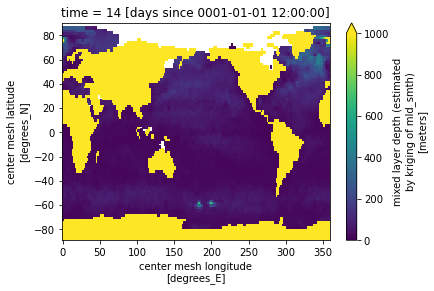

In [5]:
ds_in.mld[0,:].plot(vmin=0, vmax=1000);

In [6]:
# mask bad values
for t in range(len(ds_in.time)):
    tmp = np.nan_to_num(ds_in.mld[t,:].values, copy=True, posinf=0, neginf=0)
    ds_in['mld'][t,:,:] = tmp #.where(tmp == tmp).where(tmp>=0).where(tmp<1.0e6)

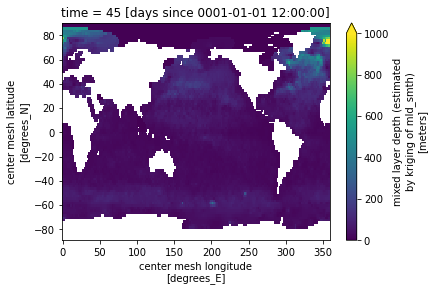

In [7]:
ds_in.mld[1,:].where(ds_in.mask==1).plot(vmin=0, vmax=1000)

In [8]:
def regrid_mld(fld, ds_in, ds_out, method='bilinear'):

    regrid = xesmf.Regridder(
        ds_in,
        ds_out,
        method=method,
        periodic=True,
    )
    fld_out = regrid(ds_in[fld])
    return fld_out

In [9]:
ds_out = regrid_mld('mld', ds_in, ds_out).rename('mld')

## Visual inspection 
Make sure original and remapped plots look similar.

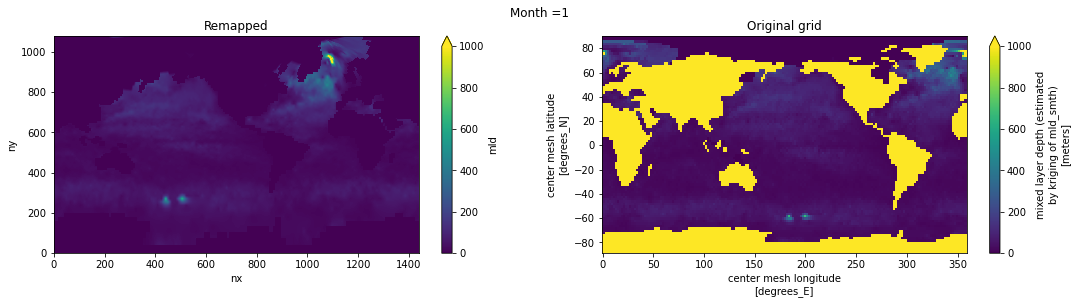

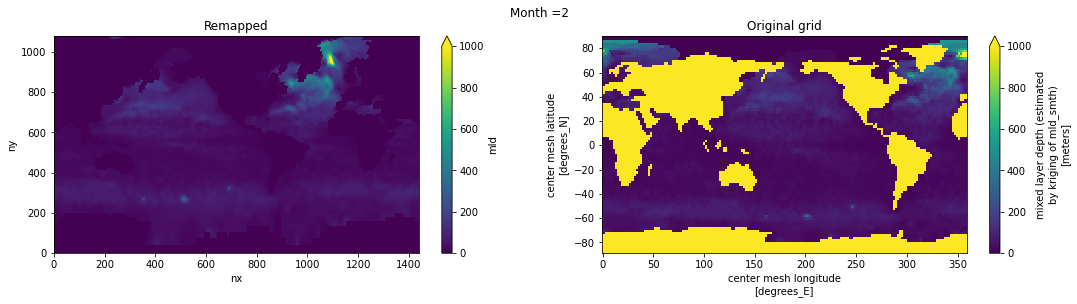

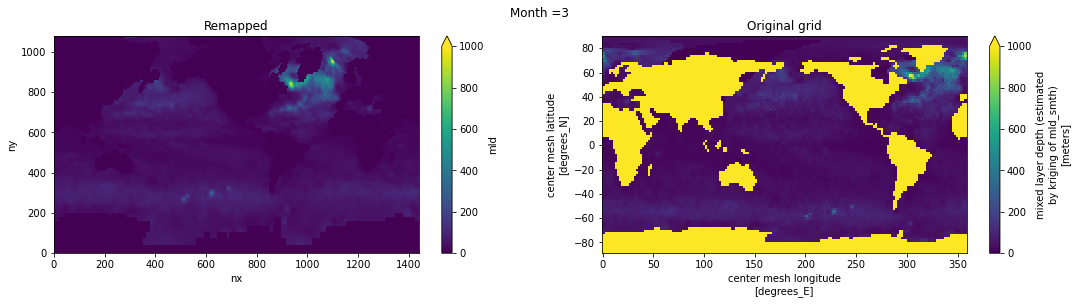

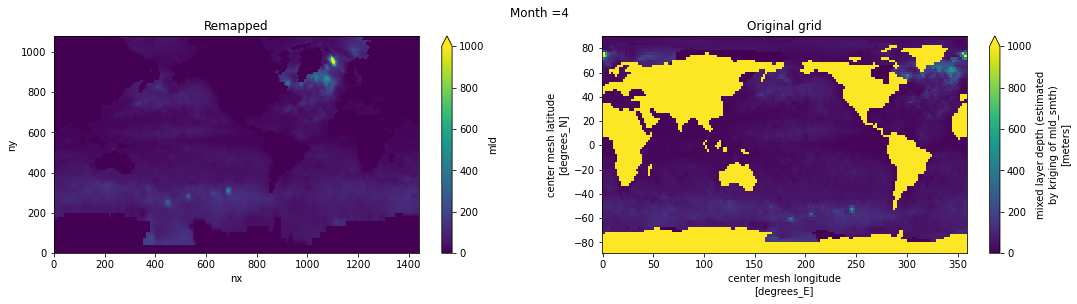

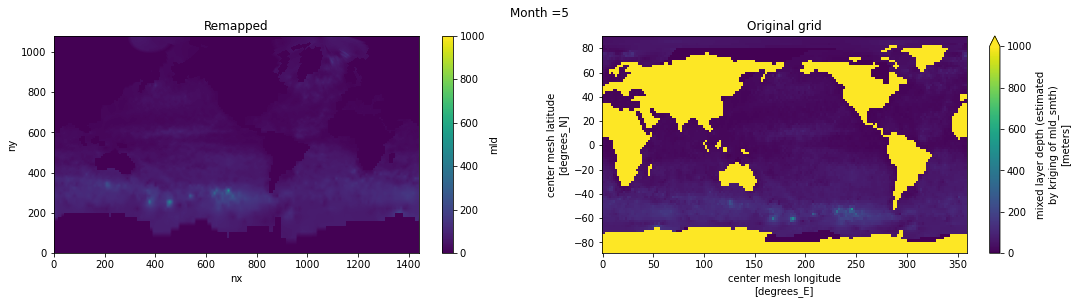

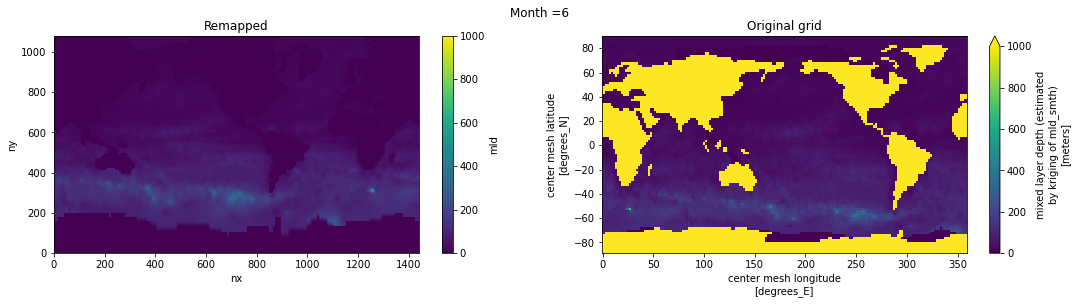

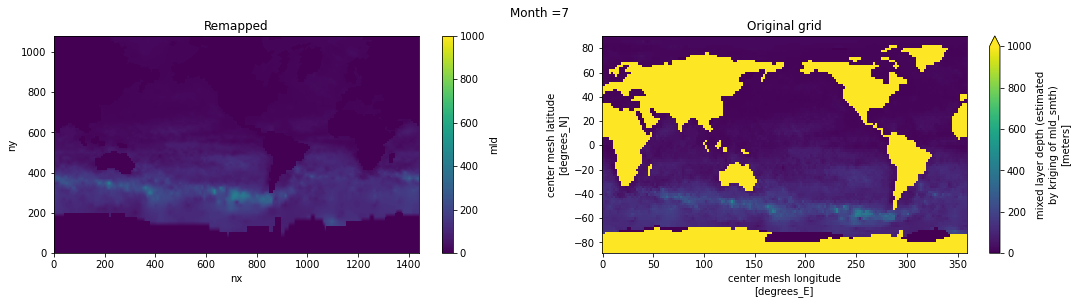

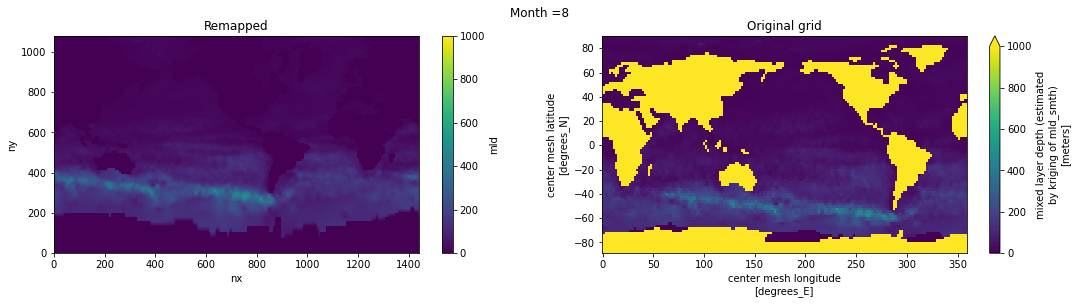

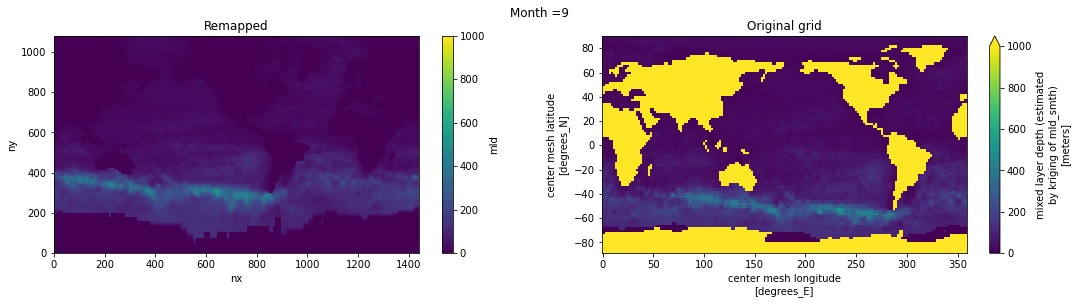

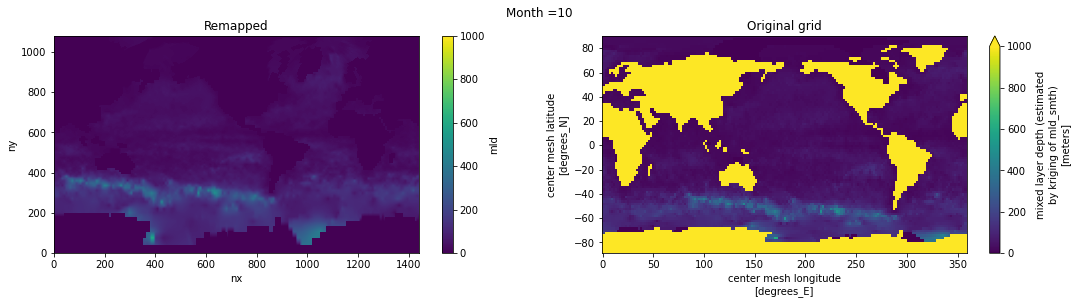

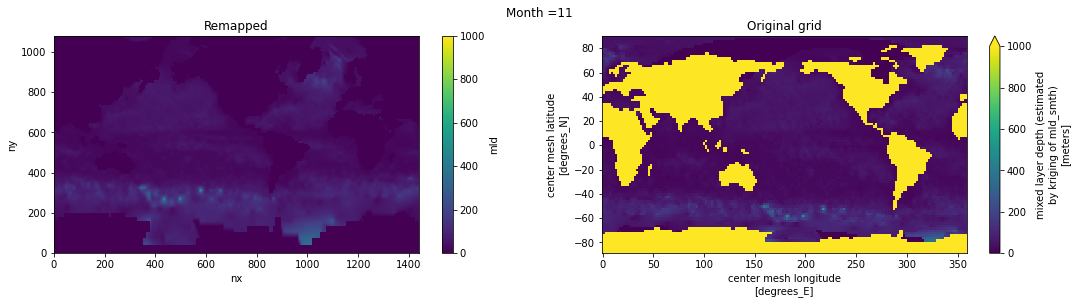

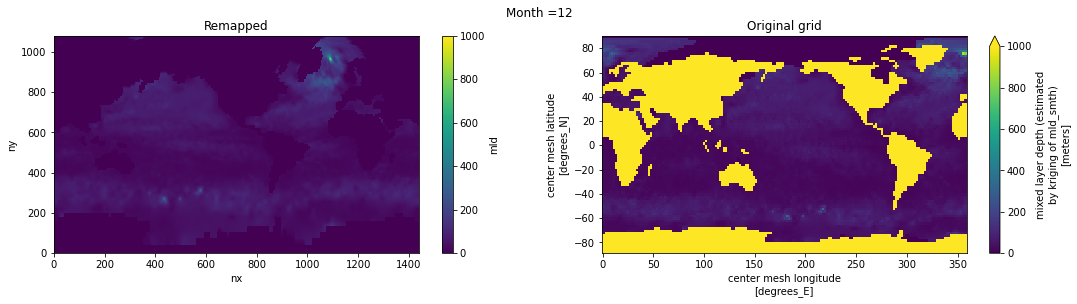

In [10]:
# visual inspection. Make sure original and remapped plots look similar
for t in range(len(ds_in.time)):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,4))
  ds_out[t,:,:].plot.pcolormesh(ax=axes[0], vmin=0,vmax=1000)
  ds_in['mld'][t,:,:].plot.pcolormesh(ax=axes[1], vmin=0,vmax=1000)
  axes[0].set_title('Remapped')
  axes[1].set_title('Original grid')
  plt.suptitle('Month ='+ str(t+1))

In [11]:
ds_out.attrs['author'] = 'Gustavo Marques (gmarques@ucar.edu)'
ds_out.attrs['description'] = 'MLD using density criterion of 0.03 kg/m3 difference (de Boyer Montegut et al., JGR 2004)'
ds_out.attrs['date'] = datetime.now().isoformat()
ds_out.attrs['infile'] = infile
ds_out.attrs['url'] = 'https://github.com/NCAR/tx1_4/mld/deBoyer2004/'
# save
fname = 'deBoyer04_MLD_remapped_to_tx1_4.nc'
ds_out.to_netcdf(fname)